In [8]:
import networkx as nx
import time
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
# from networkx.algorithms import community
import community as louvain
import matplotlib.cm as cm
import matplotlib.colors as mpcol
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
from community import community_louvain

%matplotlib inline

In [9]:
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.1'

In [10]:
def undirected_network(G):
    G_simple = nx.Graph()
    for i,j,data in G.edges(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G_simple.has_edge(i,j):
            G_simple[i][j]['weight'] += w
        else:
            G_simple.add_edge(i,j,weight=w)
    return G_simple

In [11]:
def find_communities(G):
    start_time = time.time()
    partition = community_louvain.best_partition(G)
    part_dict = {}
    values = []
    for node in G.nodes():
        values.append(partition.get(node))
        part_dict.update({node:partition.get(node)})
    communities_louvain1 = max(values)+1
    end_time = time.time()
    mod_louvain = community_louvain.modularity(partition,G)
    print('Communities found using the Louvain algorithm: {} \nModularity: {} \nTime for finding the communities: {} s'.format(communities_louvain1, mod_louvain,round((end_time-start_time),3)))
    return part_dict

In [12]:

def plot_communities(city_sw):
    
    #List of color
    Color_barragan = ['#E1CF3F','#F47757','#FD4581','#97577C','#BDA7A9','#E1CF3F','#F47757','#FD4581',
                 '#e44623','#e45a6a','#c9d3e6','#7d513d',
                 '#e65949','#d6b240','#382a29','#d8d4c9',
                 '#e4cc34','#ccb42c','#bc8ca4','#3c84c4',
                 '#dd4d3d','#52172f','#63494a','#e2d5d3',
                 '#f7abcc','#e085a1','#943d39','#2d1d19']
    #Create the color map
    Barragan = mpcol.ListedColormap(Color_barragan, name='Barragan')
    G_drive = ox.project_graph(city_sw)
    G_simple = undirected_network(G_drive)
    part_dict = find_communities(G_simple)
    nx.set_node_attributes(G_drive, part_dict, 'community')
    communities = [(G_drive.nodes()[i]['community']) for i in G_drive.nodes()]
    com = [x[1] for x in G_drive.nodes(data='community')]
    norm = mpcol.Normalize(vmin=min(com), vmax=max(com), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=Barragan)
    nc=[mapper.to_rgba(x) for x in com]
    save = True

    fig, ax = ox.plot_graph(G_drive, bgcolor='black', node_color=nc, node_size=8.5, node_zorder=3, node_alpha=1, 
                        edge_linewidth=0.25, edge_color='white',edge_alpha=1,close=True, show=True,
                         save=save)

In [27]:
# get street networks by location name
def get_street_network(location):
    G = ox.graph_from_place(location)
    ox.plot_graph(G)

#get street network from polygon and save to shp
def get_street_network_shp(location, location_name):
    polygon = location.iloc[0]['geometry']
    G = ox.graph_from_polygon(polygon)
    ox.save_graph_shapefile(G, filepath=location_name)
    ox.plot_graph(G)
    return G  

#get network metrics
def get_network_metrics(city_sw, location_name):
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(city_sw)
    gdf_nodes.to_csv(f'drone-network-metrics/{location_name}-nodes.csv')
    gdf_edges.to_csv(f'drone-network-metrics/{location_name}-edges.csv')

    closeness_centrality = nx.closeness_centrality(city_sw)
    closeness_table = pd.DataFrame(list(closeness_centrality.items()))
    closeness_table.to_csv(f'drone-network-metrics/{location_name}-closeness.csv')
    
    betweeness_centrality = nx.betweenness_centrality(ox.get_digraph(city_sw), weight='length')
    betweeness_table = pd.DataFrame(list(betweeness_centrality.items()))
    betweeness_table.to_csv(f'drone-network-metrics/{location_name}-betweeness.csv')

#     page_rank = nx.pagerank(city_sw, alpha=0.8)
#     page_rank_table = pd.DataFrame(list(page_rank.items()))
#     page_rank.to_csv(f'network-metrics/{location_name}-page_rank.csv')

    return gdf_nodes, gdf_edges, closeness_table, betweeness_table

In [23]:
# load shapefiles of new wave cities

# la trinidad city
la_trinidad = gpd.read_file('drone-cities-shp/Trinidad.shp')

# taytay city
taytay = gpd.read_file('drone-cities-shp/Taytay.shp')

# dumaguete city
dumaguete = gpd.read_file('drone-cities-shp/Dumaguete.shp')


# Street Networks

## La Trinidad City

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


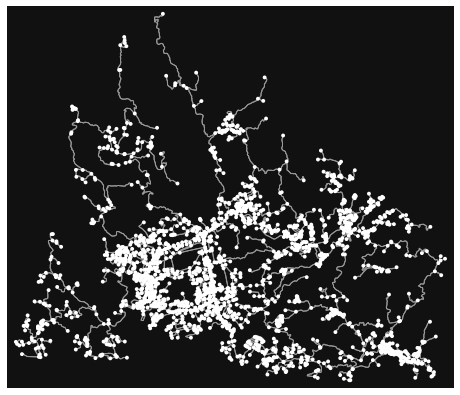

In [18]:
la_trinidad_sw = get_street_network_shp(la_trinidad, "la_trinidad_sw")
la_trinidad_sw

Communities found using the Louvain algorithm: 47 
Modularity: 0.947592425383624 
Time for finding the communities: 0.3 s


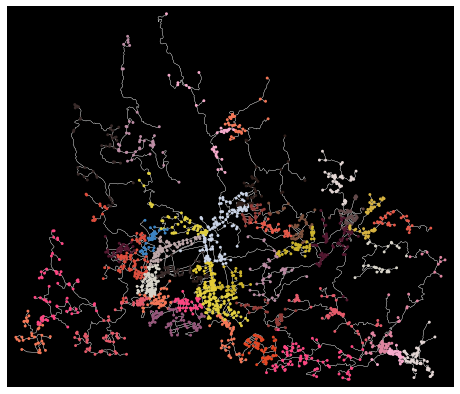

In [28]:
# plot communities
plot_communities(la_trinidad_sw)

In [29]:
get_network_metrics(la_trinidad_sw,'la-trinidad')

(                    y           x  street_count highway  \
 osmid                                                     
 16985637    16.446813  120.591028             3     NaN   
 16987440    16.447852  120.576403             3     NaN   
 16987449    16.447086  120.576927             3     NaN   
 16987456    16.446442  120.577427             3     NaN   
 16987974    16.445279  120.586179             4     NaN   
 ...               ...         ...           ...     ...   
 9116875658  16.438233  120.629988             1     NaN   
 9136599115  16.433934  120.637135             1     NaN   
 9136611986  16.464388  120.631516             1     NaN   
 9136611991  16.464663  120.631303             3     NaN   
 9136611998  16.464976  120.631198             1     NaN   
 
                               geometry  
 osmid                                   
 16985637    POINT (120.59103 16.44681)  
 16987440    POINT (120.57640 16.44785)  
 16987449    POINT (120.57693 16.44709)  
 1698745

## Taytay City

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


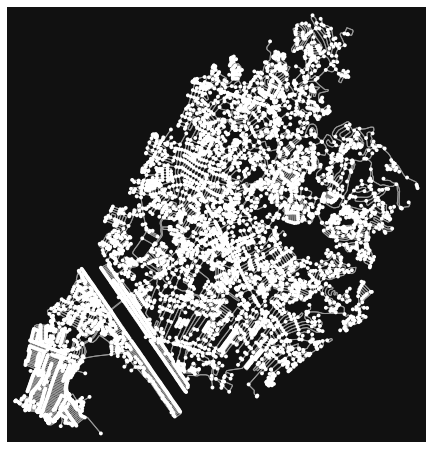

In [20]:
taytay_sw = get_street_network_shp(taytay,'taytay_sw')
taytay_sw

In [30]:
get_network_metrics(taytay_sw,'taytay')

(                    y           x  street_count highway  \
 osmid                                                     
 32436470    14.557880  121.136356             3     NaN   
 32436491    14.577579  121.143273             4     NaN   
 32436553    14.565867  121.131902             3     NaN   
 123479003   14.556723  121.131333             3     NaN   
 165952233   14.577910  121.144219             3     NaN   
 ...               ...         ...           ...     ...   
 9010328822  14.534076  121.114324             3     NaN   
 9010328826  14.533877  121.114142             1     NaN   
 9010328829  14.534053  121.114537             3     NaN   
 9010328830  14.534462  121.114619             1     NaN   
 9010328831  14.533582  121.114414             1     NaN   
 
                               geometry  
 osmid                                   
 32436470    POINT (121.13636 14.55788)  
 32436491    POINT (121.14327 14.57758)  
 32436553    POINT (121.13190 14.56587)  
 1234790

Communities found using the Louvain algorithm: 69 
Modularity: 0.9621582491377656 
Time for finding the communities: 0.85 s


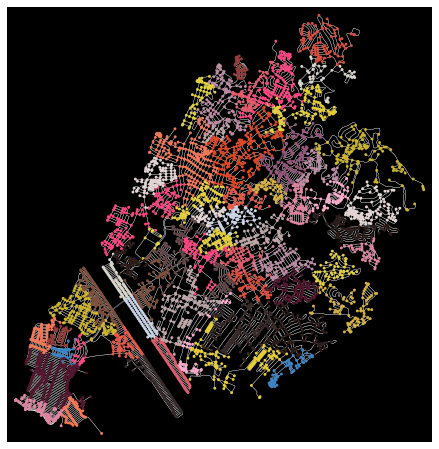

In [21]:
# plot communities
plot_communities(taytay_sw)

## Dumaguete City 

C:\Users\rache\anaconda3\lib\site-packages\osmnx\io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


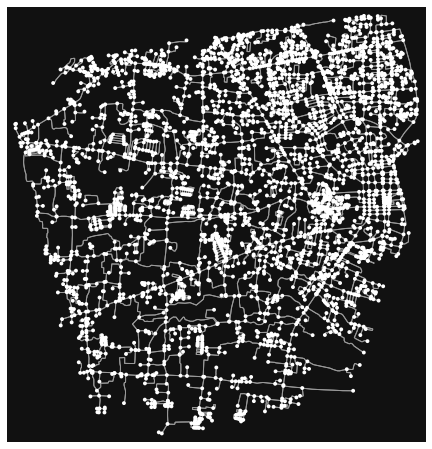

In [24]:
dumaguete_sw = get_street_network_shp(dumaguete,'dumaguete_sw')
dumaguete_sw

In [31]:
get_network_metrics(dumaguete_sw,'dumaguete')

(                   y           x  street_count highway  \
 osmid                                                    
 268429212   9.310123  123.289679             3     NaN   
 268429217   9.309347  123.306345             4     NaN   
 268429296   9.304752  123.310525             4     NaN   
 268429352   9.304204  123.308539             4     NaN   
 268429419   9.304256  123.310612             3     NaN   
 ...              ...         ...           ...     ...   
 9119199903  9.329199  123.287903             3     NaN   
 9119413439  9.272375  123.275140             1     NaN   
 9119413440  9.272215  123.275577             3     NaN   
 9125642723  9.328852  123.283296             1     NaN   
 9125646595  9.328797  123.283491             3     NaN   
 
                              geometry  
 osmid                                  
 268429212   POINT (123.28968 9.31012)  
 268429217   POINT (123.30635 9.30935)  
 268429296   POINT (123.31053 9.30475)  
 268429352   POINT (123.30

Communities found using the Louvain algorithm: 51 
Modularity: 0.9455833457414803 
Time for finding the communities: 0.749 s


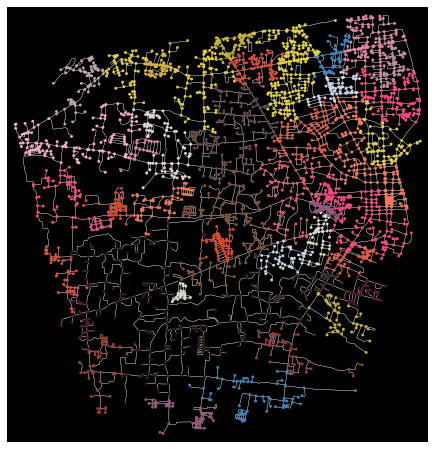

In [25]:
# plot communities
plot_communities(dumaguete_sw)